<a href="https://colab.research.google.com/github/shobiiiii/Backtester/blob/main/rebuilding_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Getting Data
import os
import yfinance as yf
import matplotlib.pyplot as plt

def fetch_data(asset_type, symbol, start_date, end_date, interval='1d'):
    """
    Fetch historical price data for the given asset type and symbol.

    :param asset_type: A string representing the asset type ("forex", "crypto", or "stock")
    :param symbol: A string representing the asset's symbol (e.g., "EURUSD" for forex, "BTC-USD" for crypto, "TSLA" for stock)
    :param start_date: A string representing the start date in the format 'YYYY-MM-DD'
    :param end_date: A string representing the end date in the format 'YYYY-MM-DD'
    :return: A pandas DataFrame containing historical price data
    """
    if asset_type == "forex":
        symbol = f"{symbol}=X"
    csv_filename = f"{symbol}_from_{start_date}_to_{end_date}_interval_{interval}.csv"
    yf_symbol = yf.Ticker(symbol)
    hist_data = yf_symbol.history(start=start_date, end=end_date, interval=interval)
    save_to_csv(data=hist_data, symbol=symbol, start_date=start_date, end_date=end_date, interval=interval)
    return hist_data

def plot_data(symbol, hist_data, start_date, end_date):
    """
    Plot the historical price data for the given symbol.

    :param symbol: A string representing the asset's symbol
    :param hist_data: A pandas DataFrame containing historical price data
    :param start_date: A string representing the start date in the format 'YYYY-MM-DD'
    :param end_date: A string representing the end date in the format 'YYYY-MM-DD'
    """
    plt.plot(hist_data.index, hist_data['Close'])
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f"{symbol} Price ({start_date} to {end_date})")
    plt.grid(True)
    plt.show(block=False)
    # plt.pause(1)
    # input()
    # plt.close()

def save_to_csv(data, symbol, start_date, end_date, interval, dir_name='data'):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    file_name = f"{symbol}_from_{start_date}_to_{end_date}_interval_{interval}.csv"
    file_path = os.path.join(dir_name, file_name)
    if os.path.exists(file_path) and os.path.getsize(file_path) > 42:
        print("CSV File Already Exist.")
        return
    else:
        data.to_csv(file_path)
        print(f"Data saved to {file_path}")



CSV File Already Exist.


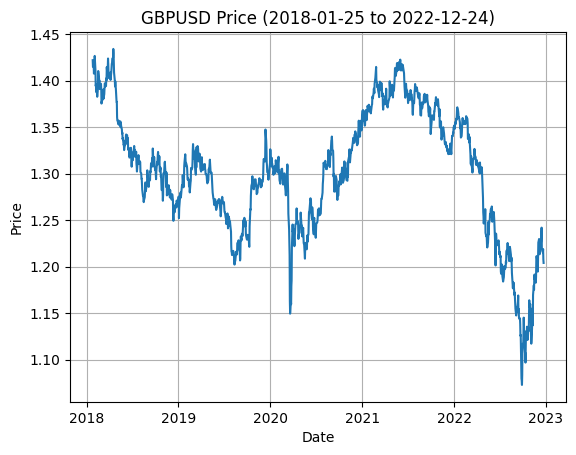

In [ ]:
# Fetching Data
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Specify start and end dates, asset type, symbol, and interval
start_date = '2018-01-25'
end_date = '2022-12-24'
asset_type = "forex"  # Options: "forex", "crypto", "stock"
symbol = "GBPUSD"  # formats: "EURUSD", "BTC-USD", "TSLA"
interval = "1d"  # Options: "1m", "5m", "15m", "30m", "60m", "1d", "1wk", "1mo"

# Fetch and plot data
data = fetch_data(asset_type, symbol, start_date, end_date, interval=interval)
plot_data(symbol, data, start_date, end_date)



In [ ]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Adding Returns and Technical Indicators
import pandas as pd
from ta.volatility import AverageTrueRange
from ta.trend import CCIIndicator
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator

# Calculate returns and lagged returns
data['Returns'] = data['Close'].pct_change().dropna()
data['Lagged_Returns'] = data['Returns'].shift(1).dropna()


periods = [3, 7, 14, 21]

for period in periods:
    # Calculate SMA and EMA
    data[f'SMA_{period}'] = data['Close'].rolling(window=period).mean()
    data[f'EMA_{period}'] = data['Close'].ewm(span=period).mean()

    # Calculate RSI
    rsi = RSIIndicator(data['Close'], window=period).rsi()
    data[f'RSI_{period}'] = rsi

    # Calculate ATR
    atr = AverageTrueRange(data['High'], data['Low'], data['Close'], window=period).average_true_range()
    data[f'ATR_{period}'] = atr

    # Calculate CCI
    cci = CCIIndicator(data['High'], data['Low'], data['Close'], window=period).cci()
    data[f'CCI_{period}'] = cci

# Calculate OBV if asset_type is "stock"
if asset_type == "stock":
    obv = OnBalanceVolumeIndicator(data['Close'], data['Volume']).on_balance_volume()
    data[f'OBV'] = obv

    # Calculate OBV_SMA for different periods
    for period in periods:
        data[f'OBV_SMA_{period}'] = data['OBV'].rolling(window=period).mean()


# Drop any NaN rows created due to the indicator calculations
data.dropna(inplace=True)

# Create the categorical features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['quarter'] = data.index.quarter

# Perform one-hot encoding
data = pd.get_dummies(data, columns=['day_of_week', 'month', 'quarter'])
data


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Lagged_Returns,SMA_3,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-22 00:00:00+00:00,1.391014,1.395206,1.385809,1.391014,0,0.0,0.0,-0.006496,0.000602,1.396797,...,0,0,0,0,0,0,1,0,0,0
2018-02-23 00:00:00+00:00,1.395128,1.400482,1.392506,1.395303,0,0.0,0.0,0.003084,-0.006496,1.395476,...,0,0,0,0,0,0,1,0,0,0
2018-02-26 00:00:00+00:00,1.396921,1.407261,1.393340,1.396804,0,0.0,0.0,0.001076,0.003084,1.394374,...,0,0,0,0,0,0,1,0,0,0
2018-02-27 00:00:00+00:00,1.396453,1.399443,1.386174,1.396648,0,0.0,0.0,-0.000112,0.001076,1.396252,...,0,0,0,0,0,0,1,0,0,0
2018-02-28 00:00:00+00:00,1.390337,1.391595,1.377771,1.390608,0,0.0,0.0,-0.004325,-0.000112,1.394687,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19 00:00:00+00:00,1.216072,1.224155,1.212342,1.216027,0,0.0,0.0,-0.002371,-0.018540,1.225629,...,0,0,0,0,0,1,0,0,0,1
2022-12-20 00:00:00+00:00,1.215600,1.221926,1.208693,1.215333,0,0.0,0.0,-0.000571,-0.002371,1.216759,...,0,0,0,0,0,1,0,0,0,1
2022-12-21 00:00:00+00:00,1.218918,1.219036,1.207103,1.218918,0,0.0,0.0,0.002950,-0.000571,1.216759,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Returns', 'Lagged_Returns', 'SMA_3', 'EMA_3', 'RSI_3', 'ATR_3',
       'CCI_3', 'SMA_7', 'EMA_7', 'RSI_7', 'ATR_7', 'CCI_7', 'SMA_14',
       'EMA_14', 'RSI_14', 'ATR_14', 'CCI_14', 'SMA_21', 'EMA_21', 'RSI_21',
       'ATR_21', 'CCI_21', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4'],
      dtype='object')

In [ ]:
# Select relevant features
if asset_type == "forex":
  columns_to_drop = ['Returns', 'Lagged_Returns', 'Volume', 'Dividends', 'Stock Splits']
else:
  columns_to_drop = ['Returns', 'Lagged_Returns', 'Dividends', 'Stock Splits']

features = data.drop(columns=columns_to_drop)
target = data[['Lagged_Returns']]
target

,Lagged_Returns
Date,
2018-02-22 00:00:00+00:00,0.000602
2018-02-23 00:00:00+00:00,-0.006496
2018-02-26 00:00:00+00:00,0.003084
2018-02-27 00:00:00+00:00,0.001076
2018-02-28 00:00:00+00:00,-0.000112
...,...
2022-12-19 00:00:00+00:00,-0.018540
2022-12-20 00:00:00+00:00,-0.002371
2022-12-21 00:00:00+00:00,-0.000571


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target)

# Split the data into training and testing sets
train_size = int(len(scaled_features) * 0.8)
train_data = scaled_features[:train_size]
test_data = scaled_features[train_size:]


In [ ]:
scaled_target[-1]

array([-0.1062439])

In [ ]:
# Creating Sequences
# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(scaled_features[i - sequence_length:i])
        y.append(scaled_target[i, -1])
    return np.array(X), np.array(y)

sequence_length = 15

# Create sequences for training and testing sets
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [ ]:
# len(X_train)
# len(train_data)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(993, 15, 45)
(993,)
(238, 15, 45)
(238,)


In [ ]:
# hyperparameter tuning
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam

# Function to create the LSTM model
def create_model(optimizer=Adam(lr=0.001), lstm_layers=[50], dropout_rate=0.2):
    model = Sequential()
    for i, units in enumerate(lstm_layers):
        if i == 0:
            model.add(LSTM(units, activation='relu', return_sequences=True if len(lstm_layers) > 1 else False, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units, activation='relu', return_sequences=True if i < len(lstm_layers) - 1 else False))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap the Keras model with KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)


<ipython-input-96-da6c88059dae>:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [ ]:
# hyper paramater tuning using grid search and random search

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit,RandomizedSearchCV

# Define the hyperparameter search space
param_grid = {
    'lstm_layers': [ [50]],
    'dropout_rate': [0.4],
    'optimizer': [Adam(lr=0.01)],
    'batch_size': [20],
    'epochs': [10]
}

# Perform Grid Search using GridSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
grid_search = grid.fit(X_train, y_train)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, cv=3)

# Fit the random_search to your data
#random_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best score: {grid_search.best_score_} using {grid_search.best_params_}")
# print(f"Best score: {random_search.best_score_} using {random_search.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: -0.013759566936641932 using {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 10, 'lstm_layers': [50], 'optimizer': <keras.optimizers.legacy.adam.Adam object at 0x7ff218887dc0>}


In [ ]:
# TODO: hyperparamters tuning using bayesian search


In [ ]:
# train the model and predict the future price

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import tensorflow as tf
tf.config.run_functions_eagerly(True)


# Function to create the LSTM model using the best hyperparameters
def create_best_model(optimizer, lstm_layers, dropout_rate):
    model = Sequential()
    for i, units in enumerate(lstm_layers):
        if i == 0:
            model.add(LSTM(units, return_sequences=True if len(lstm_layers) > 1 else False, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units, return_sequences=True if i < len(lstm_layers) - 1 else False))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create the LSTM model with the best hyperparameters from the Grid/random Search
best_params = grid_search.best_params_
# best_params = random_search.best_params_

best_model = create_best_model(
    optimizer=best_params['optimizer'],
    lstm_layers=best_params['lstm_layers'],
    dropout_rate=best_params['dropout_rate']
)

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train,
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)



Epoch 1/10
50/50 [==============================] - 4s 80ms/step - loss: 0.0535
Epoch 2/10
50/50 [==============================] - 5s 98ms/step - loss: 0.0133
Epoch 3/10
50/50 [==============================] - 6s 120ms/step - loss: 0.0122
Epoch 4/10
50/50 [==============================] - 10s 200ms/step - loss: 0.0099
Epoch 5/10
50/50 [==============================] - 9s 177ms/step - loss: 0.0085
Epoch 6/10
50/50 [==============================] - 9s 180ms/step - loss: 0.0074
Epoch 7/10
50/50 [==============================] - 4s 84ms/step - loss: 0.0058
Epoch 8/10
50/50 [==============================] - 4s 81ms/step - loss: 0.0060
Epoch 9/10
50/50 [==============================] - 4s 75ms/step - loss: 0.0054
Epoch 10/10
50/50 [==============================] - 4s 78ms/step - loss: 0.0046


In [ ]:
# checking the model performace over train data
Y_train_pred = best_model.predict(X_train)

32/32 [==============================] - 1s 44ms/step


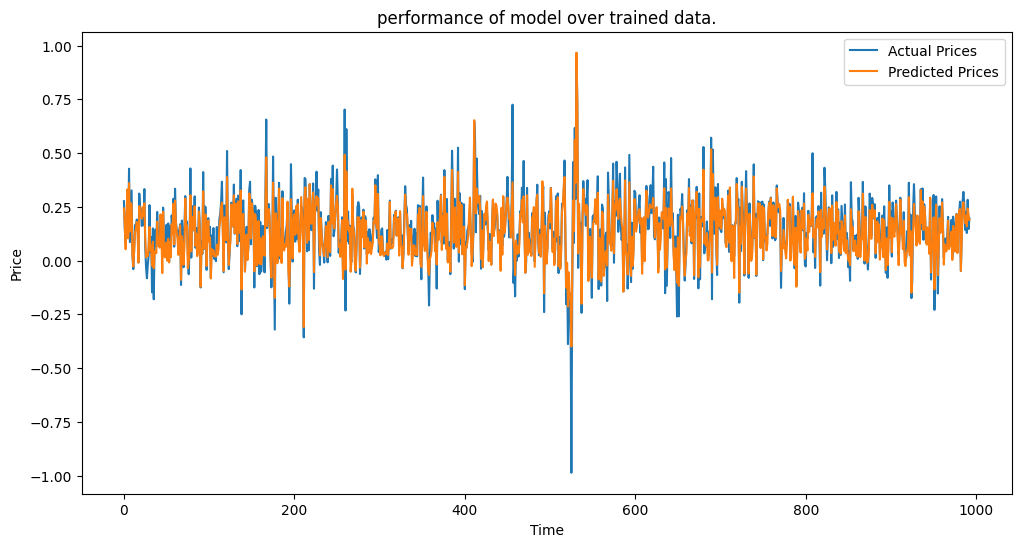

In [ ]:
# Plotting train prediction against actual
plt.figure(figsize=(12, 6))
plt.title("performance of model over trained data.")
plt.plot(y_train, label="Actual Prices")
plt.plot(Y_train_pred, label="Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
# Predict future stock returns using the test dataset
y_pred = best_model.predict(X_test)

# If you want to convert the predicted returns to prices, you can do so using the following code:
last_known_price = data.iloc[-len(y_test)-1]['Close']
y_pred_prices = [last_known_price * (1 + return_pred) for return_pred in np.squeeze(y_pred)]
for i in range(1, len(y_pred_prices)):
    y_pred_prices[i] = y_pred_prices[i - 1] * (1 + y_pred[i])


8/8 [==============================] - 0s 51ms/step


MAE: 0.03761563639934678
MSE: 0.0024548855299139625
RMSE: 0.04954680140951545
MAPE: 0.5491733538806804


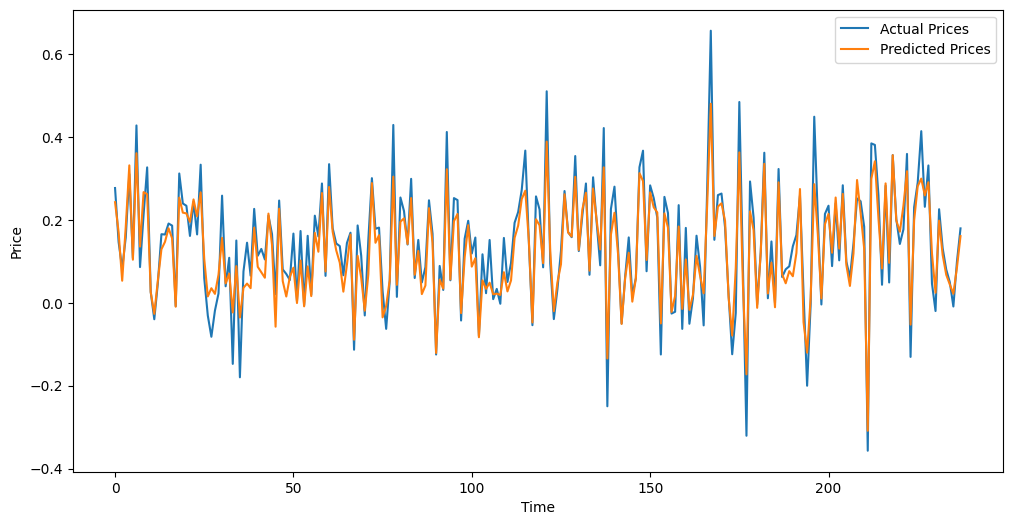

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nMAPE: {mape}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(y_pred, label="Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


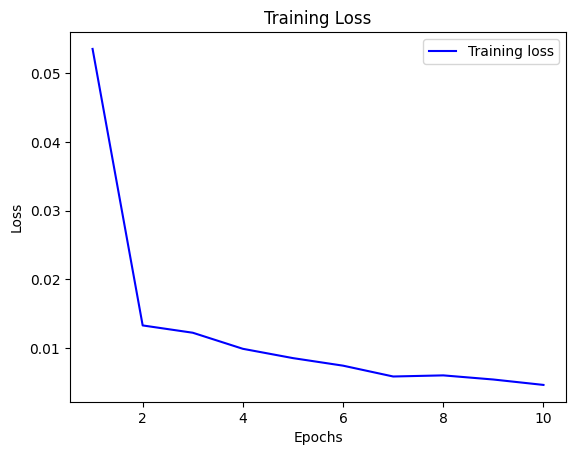

In [ ]:
#plotting loss function

# Get the training loss values from the history object
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plot the loss values
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
last_row = X_test[-1]
last_row = last_row[None, :, :]
tomorrow_predicted_return = best_model.predict(last_row)
unscaled_return = scaler.inverse_transform(tomorrow_predicted_return)
tomorrow_predicted_price = (1 + unscaled_return) * features.iloc[-1]['Close']
tomorrow_predicted_price

In [ ]:
features.iloc[-5:]['Close']

Date
2022-12-19 00:00:00+00:00    1.216027
2022-12-20 00:00:00+00:00    1.215333
2022-12-21 00:00:00+00:00    1.218918
2022-12-22 00:00:00+00:00    1.207740
2022-12-23 00:00:00+00:00    1.203992
Name: Close, dtype: float64

In [ ]:
import pytz

def predict_price_on_date(date, features, model, scaler, sequence_length=15, print_details=False):

    # Convert the input date to a timezone-aware object
    tz = pytz.timezone('America/New_York')
    date = pd.to_datetime(date).tz_localize(features.index.tz)
    
    # Find the index of the given date
    date_index = features.index.get_loc(date)

    # Check if there is enough historical data for the given date
    if date_index < sequence_length:
        print("Not enough historical data for the given date.")
        return None

    # Calculate the index for X_test and check if it's within the valid range
    x_test_index = date_index - train_size - sequence_length
    if x_test_index < 0 or x_test_index >= len(X_test):
        print(f"No data available for the date {date}.")
        print(date_index - train_size - sequence_length, date_index, train_size, sequence_length, len(X_test))
        return None

    # Assigning the matching record of X_test to our target date
    row = X_test[x_test_index]

    # Reshape the input data to match the input shape required by the model
    input_data = row[None, :, :]
    
    # Predict the return for the given date using the model
    predicted_return = model.predict(input_data, verbose=0)

    # Unscale the return using the appropriate scaler.inverse_transform method
    unscaled_return = scaler.inverse_transform(predicted_return)

    # Calculate the predicted price for the given date
    previous_close_price = features.iloc[date_index - 1]["Close"]
    predicted_price = (1 + unscaled_return) * features.iloc[-1]['Close']

    # Calculate the actual price for the given date
    actual_price = features.iloc[date_index]["Close"]

    # Calculate the prediction error
    error = actual_price - predicted_price

    # Calculate the actual and predicted directions
    actual_direction = "up" if actual_price >= previous_close_price else "down"
    predicted_direction = "up" if predicted_price >= previous_close_price else "down"

    # Print the results
    if print_details:
      print(f"Date: {date}")
      print(f"Predicted price: {predicted_price[0][0]:.5f}")
      print(f"Actual price: {actual_price:.5f}")
      print(f"Error: {error[0][0]:.5f}")
      print(f"Actual direction: {actual_direction}")
      print(f"Predicted direction: {predicted_direction}")

    return predicted_price[0][0], actual_price, error[0][0], actual_direction, predicted_direction


In [ ]:
date = "2022-12-20"
predicted_price, actual_price, error, actual_direction, predicted_direction = predict_price_on_date(date, features, best_model, scaler, print_details=True)


Date: 2022-12-20 00:00:00+00:00
Predicted price: 1.19948
Actual price: 1.21533
Error: 0.01585
Actual direction: down
Predicted direction: down


In [ ]:
# date_index = target.index.get_loc(date)
# print( X_test[237].shape, X_test[-1].shape, len(X_test))
# print(date_index - train_size - sequence_length, date_index, train_size, sequence_length, len(X_test))
# X_test[date_index - train_size - sequence_length] is X_test[-1]

In [ ]:
!pip install holiday

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import holidays
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


# Get US holidays
us_holidays = holidays.US()

# Function to check if a given date is a holiday or a weekend
def is_holiday_or_weekend(date):
    # Convert the input date to a pandas Timestamp object
    pd_date = pd.Timestamp(date)
    
    # Check if date is a public holiday
    is_public_holiday = pd_date in us_holidays

    # Check if date is a weekend (Saturday or Sunday)
    is_weekend = pd_date.weekday() in (5, 6)

    # Return True if date is either a public holiday or a weekend
    return is_public_holiday or is_weekend

    is_holiday = date in us_holidays
    print(date, "date is holiday or weekend?: ", is_public_holiday, is_weekend)
    return is_holiday

from datetime import timedelta

# Main function
def calculate_statement(start_date, end_date, features, model, scaler, sequence_length=15):
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    results = []
    win_count = 0
    total_count = 0
    errors = []

    for date in pd.date_range(start_date, end_date):
        if not is_holiday_or_weekend(date):
            prediction = predict_price_on_date(date, features, best_model, scaler, sequence_length)
            if prediction is not None:
                predicted_price, actual_price, error, actual_direction, predicted_direction = prediction
                results.append(prediction)
                errors.append(error)
                if actual_direction == predicted_direction:
                    win_count += 1
                total_count += 1

    win_rate_direction = (win_count / total_count) * 100
    print(f"percentage of correct prediction of the market direction: {win_rate_direction:.2f}%")

    # Plot the error
    plt.plot(errors, marker='o')
    plt.title("Prediction Errors")
    plt.xlabel("Days")
    plt.ylabel("Error")
    plt.show()

    return results

percentage of correct prediction of the market direction: 50.67%


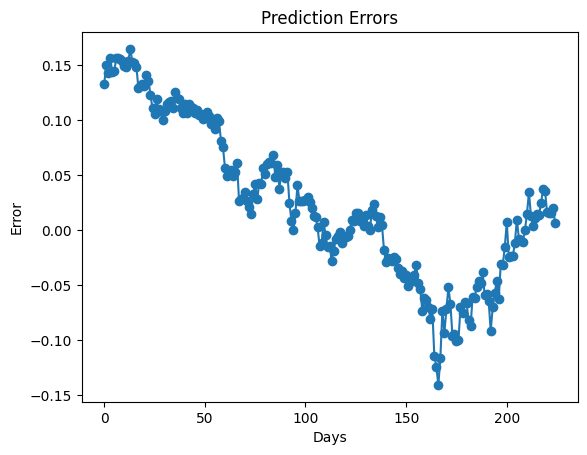

In [ ]:
results = calculate_statement("2022-2-1", "2022-12-22", features, model, scaler)